<a href="https://colab.research.google.com/github/cgrundman/ZTM-TensorFlow-Developer/blob/main/08_nlp_fundamentals_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech).

Another common term for NLP problems is sequence to sequence (seq2seq) problems.

## Check for GPU

In [2]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2024-07-20 10:35:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-20 10:35:16 (92.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disater or not disaster)

See the original here: https://www.kaggle.com/competitions/nlp-getting-started

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2024-07-20 10:35:21--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.207, 172.253.115.207, 172.253.122.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2024-07-20 10:35:21 (110 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in. One way to do so would be to read them in: https://realpython.com/read-write-files-python/

Another way to do this is to use Pandas...

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Lets visualize some random training examples
import random
random_index = random.randint(1, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disastor)" if target > 0 else "(not real disastor)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disastor)
Text:
CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring

---

Target: 1 (real disastor)
Text:
#reno Truck trailer catches fire in Reno http://t.co/k5FIJaNkJb

---

Target: 1 (real disastor)
Text:
@NickLee8  i went to school in a bombed out East End of London3 families to one house no bathroom outside loo &amp; poor so whats yr point

---

Target: 0 (not real disastor)
Text:
#Landslide! Trump 25.5% Bush 12.5% http://t.co/xY41z0O5ei via @pollster @realdonaldtrump

---

Target: 0 (not real disastor)
Text:
Apply now to work for Dilawri as #BODY #SHOP/COLLISION CENTRE MANAGER in #Vancouver #jobs http://t.co/Vg7jnaH0iW http://t.co/ksHsgWGhfJ

---



### Split data into training and validation

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Use train_test_split to split training data into training and validation set
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation data
                                                                            random_state=42)

In [13]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for eah token (the size of the feature vector can be defined and this embedding can be learned)

### Text Vectorization (tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many word in our tokenization (automatically add <OOV>)
                                    standardize='lower_and_strip_punctuation',
                                    split="whitespace",
                                    ngrams=None, # create grouos of n-words?
                                    output_mode='int', # how to map tokens to number
                                    output_sequence_length=None, # How long do you want your sequences to be
                                    pad_to_max_tokens=False)

In [17]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [18]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words in ourvocabulary
max_length = 15 # max length of our sequences

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [19]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [20]:
# Create a sample sentensce and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [21]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 #hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/6AqrNanKFD #prebreak #best        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[175, 950, 510, 859,   5, 452, 688,  26, 566, 696, 159, 776, 208,
          1, 532]])>

In [22]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our vocabulary
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least 5 common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

TO make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` - the size of our vocabulary
* `output_dim` - the size of the ouput embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` - length of the sequences being passed to the embedding layer

In [23]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128,
                             input_length=max_length # how long is each input
                             )

embedding

In [24]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Back home they mad cause I chill with the white boys .        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03287324, -0.02488642, -0.02645568, ...,  0.03913982,
          0.0357257 ,  0.03684216],
        [ 0.02995814, -0.02291058, -0.01719201, ...,  0.03795203,
          0.01988972,  0.00896211],
        [ 0.04516092,  0.00900282, -0.03077879, ...,  0.0008616 ,
          0.02918996,  0.01061709],
        ...,
        [ 0.02118671,  0.01483674, -0.02463201, ..., -0.0164534 ,
          0.00854032,  0.04647825],
        [ 0.02118671,  0.01483674, -0.02463201, ..., -0.0164534 ,
          0.00854032,  0.04647825],
        [ 0.02118671,  0.01483674, -0.02463201, ..., -0.0164534 ,
          0.00854032,  0.04647825]]], dtype=float32)>

In [25]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.03287324, -0.02488642, -0.02645568, -0.02718771,  0.02294835,
        -0.01768223,  0.04026759, -0.01126919,  0.04125598,  0.00820291,
         0.0459082 ,  0.04846508, -0.01032211,  0.0202966 , -0.02895703,
        -0.0109433 ,  0.01649015,  0.0282053 , -0.03968766,  0.04484928,
        -0.00200684, -0.01995926,  0.03187109,  0.01766047, -0.03309169,
        -0.03398329,  0.01745117, -0.04034925, -0.01781557, -0.02078935,
        -0.04830226, -0.00422149, -0.04137681, -0.04247377,  0.04573898,
        -0.0356014 , -0.00683497, -0.04046222,  0.00394086, -0.00334745,
        -0.01864297, -0.02214398,  0.0282635 ,  0.00202426,  0.01658205,
         0.02490959, -0.04444659,  0.02688607, -0.03970342, -0.04246997,
        -0.00176147,  0.04699457,  0.0254622 ,  0.00722187, -0.02088697,
        -0.04074578, -0.00212831,  0.01495494, -0.00978901,  0.00307439,
         0.01847662, -0.02486154,  0.04076082,  0.01368967,  0.00358971,
  

## Modelling a text dataset (running a series of experiments)

Now we've got a way to turn out text sequences into numbers, it's time to start builging a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from SKLearn ML map: https://scikit-learn.org/1.3/tutorial/machine_learning_map/index.html
* Model 1: Feed-Forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectionsl-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling with TensorFlow:

* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning experiment, it's important to create a baseline model so your've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IFDF formula to convert our words to numbers.

**Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Out baseline model achieves ana accuracy of: {baseline_score*100:.2f}%")

Out baseline model achieves ana accuracy of: 79.27%


In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experimnets

We could evaluate all of our model's predictions with different metrics every time, however this will be cumbersome and will easily be fixed with a function.

Let's create one to compare our model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1 score

For a deep overview of many different evaluation methods, see the Sklearn documnetation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [29]:
# Function to evaluate: accuracy, precision, recall, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall, and f1 score of a binary classification model_0
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision
  model_precision = precision_score(y_true, y_pred) * 100
  # Calculate recall
  model_recall = recall_score(y_true, y_pred) * 100
  # Calculate f1_score
  model_f1 = f1_score(y_true, y_pred) * 100

  model_results = {
      "accuracy": model_accuracy,
      "precision": model_precision,
      "recall": model_recall,
      "f1": model_f1
  }

  return model_results

In [30]:
# Get Baseline Results
baseline_results = calculate_results(y_true=val_labels, y_pred=baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'precision': 88.6178861788618,
 'recall': 62.643678160919535,
 'f1': 73.4006734006734}

### Model 1: A simple dense model

In [31]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [32]:
# Build model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [33]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [34]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [35]:
# FIt the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20240720-103523
Epoch 1/5
215/215 [==============================] - 7s 25ms/step - loss: 0.6101 - accuracy: 0.6920 - val_loss: 0.5332 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 5s 23ms/step - loss: 0.4410 - accuracy: 0.8209 - val_loss: 0.4667 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 6s 28ms/step - loss: 0.3466 - accuracy: 0.8613 - val_loss: 0.4697 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 6s 30ms/step - loss: 0.2842 - accuracy: 0.8923 - val_loss: 0.4622 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 7s 31ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4806 - val_accuracy: 0.7835


In [36]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4806 - accuracy: 0.7835


[0.480591744184494, 0.7834645509719849]

In [37]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

24/24 [==============================] - 0s 3ms/step


(762, 1)

In [38]:
# Convert model prediction probabilities to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [39]:
# Calcualate out model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.34645669291339,
 'precision': 81.8815331010453,
 'recall': 67.52873563218391,
 'f1': 74.01574803149606}

In [40]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 88.6178861788618,
 'recall': 62.643678160919535,
 'f1': 73.4006734006734}

In [41]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False,  True,  True])

## Visualizing learned embeddings

In [42]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [43]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [44]:
# Get the weight matrix of embedding layer
# (thesea re the numerical reresentations of each token in our training data which have been trained for 5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFLow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [45]:
# # Create embedding files (we got thisfrom TensorFlow's word embeddings documentation)
# import io
# out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
# out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

# for index, word in enumerate(words_in_vocab):
#   if index == 0:
#     continue  # skip 0, it's padding.
#   vec = embed_weights[index]
#   out_v.write('\t'.join([str(x) for x in vec]) + "\n")
#   out_m.write(word + "\n")
# out_v.close()
# out_m.close()

In [46]:
# # Download files from Colab to upload to projector
# try:
#   from google.colab import files
#   files.download('vectors.tsv')
#   files.download('metadata.tsv')
# except Exception:
#   pass

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

**Resources:** If you want an overview of the internals of a recurrent neural network, see the following:
* MIT's sequence modeling lecture: https://youtu.be/CznICCPa63Q?si=4oY5gEz3NRP7ftK5
* Chris Olah's intro to LSTM's: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* Andrei Karpathy's the unreasonable effectiveness of recurrent neural networks: https://karpathy.github.io/2015/05/21/rnn-effectiveness/

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layres (RNNs/dense) -> Output (label probability)
```

In [47]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [48]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1329473 (5.07 MB)
Trainable params: 1329473 (5.07 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [49]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [50]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20240720-103555
Epoch 1/5
215/215 [==============================] - 15s 57ms/step - loss: 0.2242 - accuracy: 0.9272 - val_loss: 0.5136 - val_accuracy: 0.7874
Epoch 2/5
215/215 [==============================] - 13s 62ms/step - loss: 0.1576 - accuracy: 0.9415 - val_loss: 0.6954 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 13s 58ms/step - loss: 0.1265 - accuracy: 0.9533 - val_loss: 0.6708 - val_accuracy: 0.7782
Epoch 4/5
215/215 [==============================] - 11s 50ms/step - loss: 0.1038 - accuracy: 0.9593 - val_loss: 0.7427 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 13s 59ms/step - loss: 0.0799 - accuracy: 0.9691 - val_loss: 0.8754 - val_accuracy: 0.7769


In [51]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[1.11900605e-02],
       [9.09361839e-01],
       [9.99824584e-01],
       [1.77650452e-01],
       [6.53740426e-04],
       [9.96371448e-01],
       [7.05920696e-01],
       [9.99809623e-01],
       [9.99703765e-01],
       [4.95691895e-01]], dtype=float32)

In [52]:
# Convert model 2 pred probs to lables
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [53]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.69028871391076,
 'precision': 79.08496732026144,
 'recall': 69.54022988505747,
 'f1': 74.00611620795107}

In [54]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 88.6178861788618,
 'recall': 62.643678160919535,
 'f1': 73.4006734006734}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [55]:
# Create an GRU model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [56]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [57]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [58]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                    "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20240720-103702
Epoch 1/5
215/215 [==============================] - 20s 64ms/step - loss: 0.1598 - accuracy: 0.9399 - val_loss: 0.7037 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0873 - accuracy: 0.9676 - val_loss: 0.8289 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 12s 55ms/step - loss: 0.0718 - accuracy: 0.9715 - val_loss: 1.0641 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 13s 62ms/step - loss: 0.0655 - accuracy: 0.9726 - val_loss: 1.1361 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 15s 67ms/step - loss: 0.0537 - accuracy: 0.9759 - val_loss: 1.1354 - val_accuracy: 0.7743


In [59]:
# Make predictions with GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[9.7801979e-04],
       [9.1949815e-01],
       [9.9969506e-01],
       [1.0742442e-01],
       [1.2864094e-04],
       [9.9902260e-01],
       [6.7152470e-01],
       [9.9986404e-01],
       [9.9974394e-01],
       [9.1835302e-01]], dtype=float32)

In [60]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [61]:
# Calculate model 2 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 77.42782152230971,
 'precision': 78.75816993464052,
 'recall': 69.25287356321839,
 'f1': 73.70030581039757}

In [62]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 88.6178861788618,
 'recall': 62.643678160919535,
 'f1': 73.4006734006734}

### Model 4: Bidirectional RNN

Normal RNN's go from lft ot right (just like you'd read an English sentence) however, a biderectional RNN goes from right left as well as left to right.

In [63]:
# Create a Biderectional model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Birectional")

In [64]:
# Get a summary
model_4.summary()

Model: "model_4_Birectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable param

In [65]:
# Complie the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [66]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20240720-103811
Epoch 1/5
215/215 [==============================] - 15s 50ms/step - loss: 0.1045 - accuracy: 0.9714 - val_loss: 0.8696 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 10s 45ms/step - loss: 0.0538 - accuracy: 0.9774 - val_loss: 1.1022 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 15s 72ms/step - loss: 0.0463 - accuracy: 0.9790 - val_loss: 1.1978 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 19s 86ms/step - loss: 0.0401 - accuracy: 0.9807 - val_loss: 1.4904 - val_accuracy: 0.7612
Epoch 5/5
215/215 [==============================] - 18s 82ms/step - loss: 0.0422 - accuracy: 0.9794 - val_loss: 1.4454 - val_accuracy: 0.7638


In [67]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 6ms/step


array([[2.1476431e-01],
       [7.1273309e-01],
       [9.9996489e-01],
       [2.0700608e-01],
       [1.4051389e-05],
       [9.9992281e-01],
       [9.8112589e-01],
       [9.9998689e-01],
       [9.9996674e-01],
       [9.9729860e-01]], dtype=float32)

In [68]:
# Convert pred propbs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [69]:
# Calculat ethe resuts of out bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.37795275590551,
 'precision': 75.76687116564416,
 'recall': 70.97701149425288,
 'f1': 73.29376854599407}

In [70]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 88.6178861788618,
 'recall': 62.643678160919535,
 'f1': 73.4006734006734}

## Convolutional Neural Networks for Text (and other types of sequences)

We'veused CNNs for images but images are typically 2d (height x width)... however, our text data id 1D.

Previously we've used Conv2D for our image data but now we're going to use Conv1D.

THe tyical structure of a Conv1D model for sequences (in our case text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class predictions)
```

### Model 5: Conv1D

For different explaations of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D data)
* Difference between "same" and "valid" padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [71]:
# Test out our embedding layer, Conv1D layer and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["thisis a test sentence"]))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="same")
conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [72]:
# embedding_test

In [73]:
# conv_1d_output

In [74]:
# max_pool_output

In [75]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
imputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_4 (Dense)             (None, 1)              

In [76]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_conv1d")])

Saving TensorBoard log files to: model_logs/model_5_conv1d/20240720-103938
Epoch 1/5
215/215 [==============================] - 9s 36ms/step - loss: 0.1246 - accuracy: 0.9562 - val_loss: 0.9449 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0753 - accuracy: 0.9724 - val_loss: 1.0439 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0595 - accuracy: 0.9765 - val_loss: 1.1778 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0555 - accuracy: 0.9781 - val_loss: 1.2006 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0489 - accuracy: 0.9806 - val_loss: 1.2654 - val_accuracy: 0.7585


In [77]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[4.5555279e-02],
       [9.2114121e-01],
       [9.9995816e-01],
       [3.9050907e-02],
       [4.8662514e-07],
       [9.9844939e-01],
       [9.4679928e-01],
       [9.9992645e-01],
       [9.9999982e-01],
       [8.0968946e-01]], dtype=float32)

In [78]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [79]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.8530183727034,
 'precision': 75.9493670886076,
 'recall': 68.96551724137932,
 'f1': 72.28915662650603}

### Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2

In [80]:
sample_sentence

"There's a flood in my street!"

In [81]:
import tensorflow_hub as hub
import tensorflow as tf
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")
embed_samples = embed([
    sample_sentence,
    "When you call the univeral sentence encoder on a sentence, it turns it into  numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [82]:
embed_samples

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.01157025,  0.02485911,  0.02878051, ..., -0.00186124,
         0.02315822, -0.01485021],
       [ 0.03680136, -0.09122784, -0.00470381, ..., -0.03107636,
        -0.00511169, -0.00524487]], dtype=float32)>

In [83]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [84]:
# Create a model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [85]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_6_USE")])

Saving TensorBoard log files to: model_logs/model_6_USE/20240720-104049
Epoch 1/5
215/215 [==============================] - 9s 21ms/step - loss: 0.5117 - accuracy: 0.7784 - val_loss: 0.4517 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4149 - accuracy: 0.8117 - val_loss: 0.4414 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.4015 - accuracy: 0.8213 - val_loss: 0.4367 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3939 - accuracy: 0.8260 - val_loss: 0.4277 - val_accuracy: 0.8189
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3872 - accuracy: 0.8313 - val_loss: 0.4276 - val_accuracy: 0.8163


In [86]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.18375458],
       [0.8186864 ],
       [0.9867026 ],
       [0.21403354],
       [0.7876359 ],
       [0.78178203],
       [0.98497283],
       [0.9817835 ],
       [0.9458952 ],
       [0.09524313]], dtype=float32)

In [87]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [88]:
# Evaluate results of the model
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 83.12101910828027,
 'recall': 75.0,
 'f1': 78.85196374622357}

In [89]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 88.6178861788618,
 'recall': 62.643678160919535,
 'f1': 73.4006734006734}

### Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model+6` except we'll train it on 10% of the data.

In [90]:
## NOTE: Making data splits like below leads to data leakages (model 7 trained on 10 percent , outperforms model 6 trained on full data)

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

**Note:** Be *very* carefult when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [91]:
#Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [92]:
# Check the number of labeled data in our new subset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
Name: count, dtype: int64

In [93]:
train_df_shuffled["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [94]:
# Create a model
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="USE_10_percent")

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "USE_10_percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [95]:
# Fit the model
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_7_USE_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent_correct_split/20240720-104114
Epoch 1/5
22/22 [==============================] - 3s 69ms/step - loss: 0.6674 - accuracy: 0.6715 - val_loss: 0.6472 - val_accuracy: 0.7073
Epoch 2/5
22/22 [==============================] - 1s 45ms/step - loss: 0.5946 - accuracy: 0.8073 - val_loss: 0.5915 - val_accuracy: 0.7546
Epoch 3/5
22/22 [==============================] - 1s 37ms/step - loss: 0.5198 - accuracy: 0.8146 - val_loss: 0.5382 - val_accuracy: 0.7664
Epoch 4/5
22/22 [==============================] - 1s 49ms/step - loss: 0.4601 - accuracy: 0.8190 - val_loss: 0.5033 - val_accuracy: 0.7795
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4195 - accuracy: 0.8321 - val_loss: 0.4908 - val_accuracy: 0.7808


In [96]:
# Find pred propbs for model 7
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 13ms/step


array([[0.20100474],
       [0.5905854 ],
       [0.88724864],
       [0.35575053],
       [0.56070584],
       [0.6728983 ],
       [0.87305224],
       [0.81928074],
       [0.8564115 ],
       [0.1598881 ]], dtype=float32)

In [97]:
# Convert pred probs to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [98]:
# Evaluate model
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 78.08398950131233,
 'precision': 79.09967845659163,
 'recall': 70.6896551724138,
 'f1': 74.65857359635811}

In [99]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 88.6178861788618,
 'recall': 62.643678160919535,
 'f1': 73.4006734006734}

## Comparing the performance of each of our models

In [100]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,88.617886,62.643678,73.400673
1_simple_dense,78.346457,81.881533,67.528736,74.015748
2_lstm,77.690289,79.084967,69.540230,74.006116
3_gru,77.427822,78.758170,69.252874,73.700306
4_bidirectional,76.377953,75.766871,70.977011,73.293769
5_conv1d,75.853018,75.949367,68.965517,72.289157
6_tf_hub_use_encoder,81.627297,83.121019,75.000000,78.851964
7_tf_hub_use_encoder_10_percent,78.083990,79.099678,70.689655,74.658574


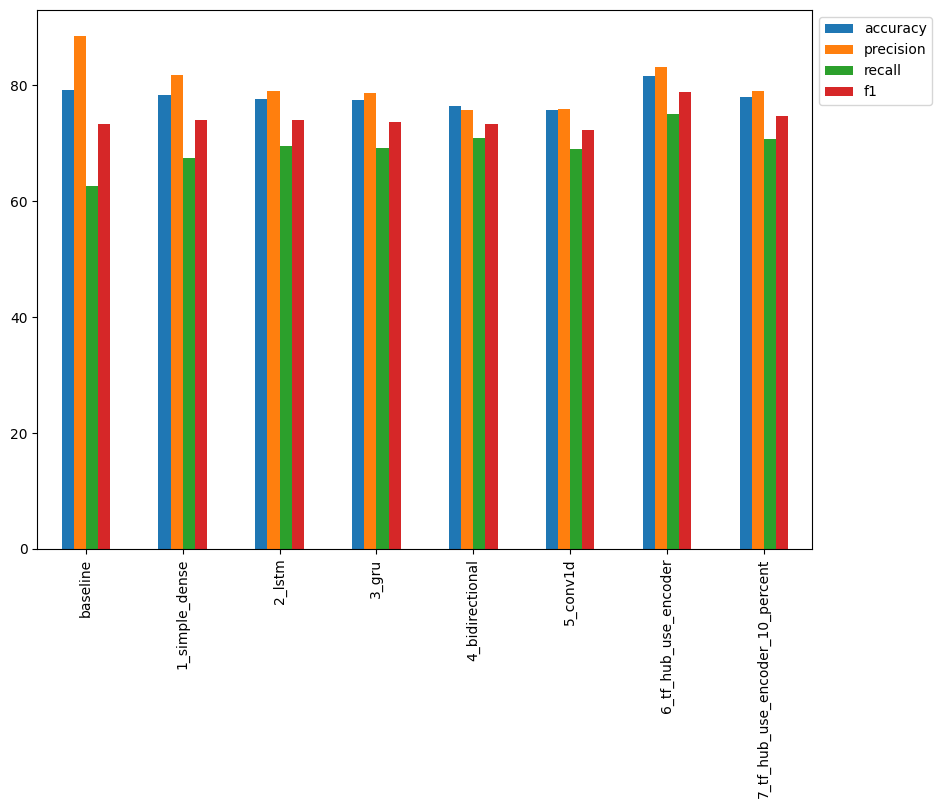

In [101]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

<Axes: >

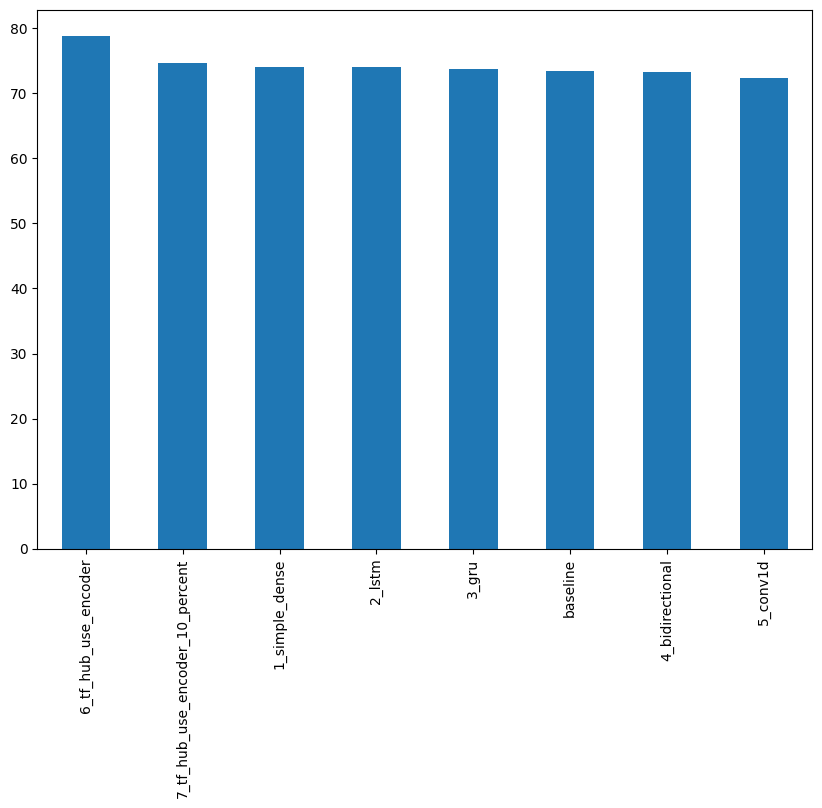

In [102]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

## Saving and Loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [103]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [104]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [105]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 18ms/step - loss: 0.4276 - accuracy: 0.8163


[0.42762312293052673, 0.8162729740142822]

Now let's save to the `SavedModel` format... (more on this here: https://www.tensorflow.org/tutorials/keras/save_and_load)

In [106]:
# Save TF Hub Sentence Encoder model to SavedModel (default)
model_6.save("model_6_SavedModel_format")

In [107]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [108]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 22ms/step - loss: 0.4276 - accuracy: 0.8163


[0.42762312293052673, 0.8162729740142822]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those with prediction probabilities closest to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vise versa.

In [111]:
# Download a pretrained model from google storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2024-07-20 11:09:09--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.207, 172.253.62.207, 172.253.115.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  50.5MB/s    in 24s     

2024-07-20 11:09:33 (38.9 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.

In [112]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 14ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [113]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 1s 24ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [116]:
# Create DataFrame with validation sentences, validation labels, and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [118]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [119]:
most_wrong.tail() # thesea are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Let's remind ourselves of the target label...
* 0 - not disaster
* 1 - disaster


In [120]:
# Check the false positive (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769820332527161
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001670837402
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [121]:
# Check the false negative (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730345636606216
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.055075839161872864
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.054603397846221924
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.05459701269865036
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963730648159981
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.04391849413514137
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.